# Wave induced motions of a floating body
The objective of this notebook is to learn about the hydrodynamic forces involved when a floating body, e.g. a ship, is exposed to incoming waves and is set into motion due to the waves. We will study this problem using potential flow theory, which leads to a mathematical problem that we call a boundary value problem (BVP).

## The boundary value problem
When we want to compute the wave induced motions of a floating body (e.g. ship) with linear potential flow theory, the mathematical problem we need to solve is governed by the Laplace equation with accompanying boundary conditions. As we have learned, the Laplace equation $\nabla^2\phi=0$ is a partial differential equation (PDE) from whitch the objective is to determine the velocity potential $\phi$ for our problem. To solve the Laplace equation requires boundary conditions (values of $\phi$ and/or $\partial\phi/\partial n$) to be prescribed on all boundaries enclosing our domain $\Omega$. Hence, this this is called a boundary value problem. The normal derivative $\partial\phi/\partial n$ is the same as the fluid velocity componponent in the normal direction to the boundary, while the value of $\phi$ (or more precisely, the change in time of $\phi$) can be related to the hydrodynamic pressure through Bernoulli's equation. For our problem, we need to specify boundary conditions on the wet surface of the floating body $S_b$, the free surface $S_f$, seabed $S_s$ and side boundaries far away from the body $S_{\infty}$, as shown in the figure below. 
<div>
<img src="Figures/BEM_problem_definition.PNG" width="600">
</div>

We have already learned how the nonlinear boundary conditions (kinematic and dynamic) on the free surface can be linearized when we assume small wave steepness. The linearized boundary value problem is:

Field equation 
$$\nabla^2\phi=0, \quad \mathrm{in}\quad \Omega $$
Boundary conditions
$$\frac{\partial\phi}{\partial n}=\mathbf{V}\cdot\mathbf{n}, \quad \mathrm{on}\quad S_b $$
$$\frac{\partial\phi}{\partial n}=0, \quad \mathrm{on}\quad S_s $$
$$-\omega^2\phi+g\frac{\partial\phi}{\partial z}=0, \quad \mathrm{on}\quad S_f $$
The condition on $S_{\infty}$ is what waves reflected or generated by the body is propagating out of the domain. This is called *radiation condition*.

## Boundary element method/Panel method
To solve a boundary value problem for a general body geometry, we must use numerical tools, as there are no analytic solutions. A family of numerical methods that has been popular in engineering for decades is called *Boundary Element Methods (BEM)* or *Panel Methods*. The mathematical details of these methods are rather complicated, but the idea behind can be explained as follows. You have already learned how we can use elementary solutions to the Laplace equation (source/sink and dipole) to construct flow fields, like the potential flow past a circular cylinder using a dipole in uniform flow. In a similar fashion, a distribution of sources and dipoles along the boundaries of our domain can be used to obtain a flow field that satisfies the boundary conditions of our problem. The strengths of the sources and dipoles are unknown and must be solved for. How the velocity potential in a given point depends on a source or dipole on the domain boundary is defined by a function called *Green's function*. The Green's function for a source and for a dipole is known. The solution depends on all sources and dipoles at the same time, and hence these unknowns must be found simultaneously. Now, the domain boundary consists of infinitely many points, which leads to infinitely many equations. Hence, we must approximate our problem by dividing the boundary into a finite number of (line/surface) panels (elements). This is called *discretization*, as we move from continuous representation of the boundary to a representation using a descrete number of elements. If we assume that the source strength is constant over each element, we obtain one equation per panel. Hence, the size of our equation system depends on the total number of panels. The system of panels used to represent the boundaries is called a *mesh*. The equation system of unknown source/dipole strengths is linear and can be solved using standard methods. When the strengths are found, the velocity potential can be computed in all points of our domain.

To improve computational efficiency by reducing the number of unknowns, a variant of the method that avoids discretization of the free surface and seabed has been developed. By applying a modified Green's function on the body panels, the boundary conditions on the free surface and on the seabed can be satisfied without a distribution of sources and dipoles at these boundaries. We then only have to discretize the body boundary. 

## Available BEM software
There are several BEM software available on the market. Most of them are proprietary and require commercial licences for use. In the following, we will make use of an open source BEM code named *Capytaine* that is released under .
Capytaine is a linear BEM solver which make use of Green's function to satisfy the boundary condition on the free surface and on the seabed. The code is available for download from github [[https://github.com/mancellin/capytaine]]. It can also be installed using conda:
>conda install -c conda-forge capytaine

We will now have a look at how Capytaine can be applied to solve our problem.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from capytaine.io.mesh_loaders import load_STL
import capytaine as cpt
from pathlib import Path
import os

In [2]:
# Let's check the current python version:
import sys
print(sys.executable)
print(sys.version)

C:\Users\davidkr\Anaconda3\envs\py37\python.exe
3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]


In [3]:
# Specify the geometry of the floating body
cylinder = cpt.HorizontalCylinder(
    length=50.0, radius=1.0,  # Dimensions
    center=(0, 0, -2),        # Position
    nr=5, nx=160, ntheta=20,   # Fineness of the mesh
)

# Let us have a look at the mesh
cylinder.mesh.show()

In [4]:
wd = Path()
#model = load_STL(os.path.join(wd,"model_geometry.stl"))
#model.mesh.show()

In [5]:
# Add the degrees of freedom that we want to solve for
cylinder.add_translation_dof(name='heave')
cylinder.add_translation_dof(name='sway')
cylinder.add_rotation_dof(name='roll')

In [6]:
# Define the range of frequencies as a Numpy array
omega_range = np.linspace(0.1, 6.0, 20)

In [7]:
# Make a list of problems that we want to solve (range of frequencies for all specified dof's)
problems = [
    cpt.RadiationProblem(body=cylinder, radiating_dof=dof, omega=omega)
    for dof in cylinder.dofs
    for omega in omega_range
]

In [8]:
# Solve all radiation problems (loop over our list of problems defined above)
solver = cpt.BEMSolver()
results = [solver.solve(pb) for pb in sorted(problems)]

Resolution of the mesh (8×max_radius=1.77e+00) might be insufficient for this wavelength (wavelength=1.71e+00)!
Resolution of the mesh (8×max_radius=1.77e+00) might be insufficient for this wavelength (wavelength=1.71e+00)!
Resolution of the mesh (8×max_radius=1.77e+00) might be insufficient for this wavelength (wavelength=1.71e+00)!


In [9]:
# Now we have a look at the results
data = cpt.assemble_dataset(results)
for item in data:
    print(item)

added_mass
radiation_damping


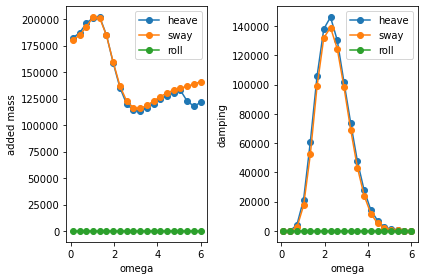

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
for dof in cylinder.dofs:
    ax1.plot(
        omega_range,
        data['added_mass'].sel(radiating_dof=dof, influenced_dof=dof),
        label=dof,
        marker='o',
    )
ax1.set_xlabel('omega')
ax1.set_ylabel('added mass')
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
for dof in cylinder.dofs:
    ax2.plot(
        omega_range,
        data['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof),
        label=dof,
        marker='o',
    )
ax2.set_xlabel('omega')
ax2.set_ylabel('damping')
ax2.legend()
plt.tight_layout()
